# Calculate Earth's secular cooling
In this notebook, we use burnman to calculate the difference in thermal energy between a hot Earth hosting a 55 GPa-deep magma ocean and (roughly) the present-day Earth. Approximations and roundings a made conservative to maximize the secular cooling so that the thermal evolution model calculates the upper bound of magma ocean lifetime.

General imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from burnman import Layer
from burnman import Planet
from physics import eos
from physics.phase_change.refractories import mc_book

## Present-day Earth

In [3]:
R_ICB   = 1221.5e3 # [m] inner-core boundary
R_CMB   = 3480e3   # [m] core-mantle boundary
R_Earth = 6371e3   # [m] planetary radius

### Core

In [4]:
from burnman.minerals.SE_2015 import liquid_iron,hcp_iron

inner_core = Layer('inner-core',radii=np.linspace(0,R_ICB))
inner_core.set_material(hcp_iron())
inner_core.set_temperature_mode('adiabatic')

outer_core = Layer('outer-core',radii=np.linspace(R_ICB,R_CMB))
outer_core.set_material(liquid_iron())
outer_core.set_temperature_mode('adiabatic')

### Mantle

In [5]:
from burnman.minerals.DKS_2013_solids import perovskite
mantle = Layer('mantle',np.linspace(R_CMB,R_Earth,100))
mantle.set_material(perovskite())

from burnman import BoundaryLayerPerturbation
TBL_T_drop    = 2200  # [K] value needed to reach a CMB temperature of 4400 K [Andrault et al., 2016]
TBL_thickness = 0     # [m] not realistic, but maximizes the secular cooling
TBL_Ra        = 1e11  # [-] We take the maximum Ra to minimize the thickness of the thermal boundary layer, and thus minimize the thermal energy of the final state
TBL           = BoundaryLayerPerturbation(radius_bottom=R_CMB,
                                          radius_top=R_Earth,
                                          rayleigh_number=TBL_Ra,
                                          temperature_change=TBL_T_drop,
                                          boundary_layer_ratio=0) # no TBL at the surface: maximizes secular cooling
T_pot_mantle = min(mc_book['Earth'].solidus) # that's colder than present day Earth's mantle potential temperature: maximizes secular cooling
mantle.set_temperature_mode('perturbed-adiabatic',
                            temperatures=TBL.temperature(mantle.radii),
                            temperature_top=T_pot_mantle)

### Compute thermal structure

In [6]:
Earth = Planet('present-day Earth',[inner_core,outer_core,mantle])
Earth.make()

## Magma-ocean Earth

### Core
We consider the core fully molten

In [7]:
molten_core = Layer('core',radii=np.linspace(0,R_CMB))
molten_core.set_material(liquid_iron())
molten_core.set_temperature_mode('adiabatic')

### Magma ocean
The unmolten lower mantle (p>55 GPa) is assumed to follow the liquid silicate adiabat. This over-estimates its temperature and thus maximizes the secular cooling.

In [8]:
from burnman.minerals.DKS_2013_liquids import MgSiO3_liquid

MO=Layer('magma ocean',radii=np.linspace(R_CMB,R_Earth))
MO.set_material(MgSiO3_liquid())

T_pot_MO = 2929 # <- for equilibrium crystallization # 2929 # <- for fractional crystallization [K] the potential temperature you need to hit the liquidus at 55 GPa
MO.set_temperature_mode('adiabatic',temperature_top=T_pot_MO)

### Compute thermal structure

In [9]:
MO_Earth = Planet('magma ocean-Earth',[molten_core,MO])
MO_Earth.make()

## Compare the MO- and present-day-Earth thermal states

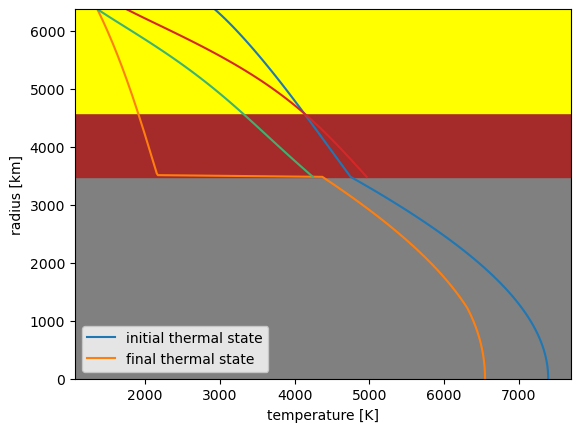

In [16]:
from scipy.optimize import root_scalar
R_MO = root_scalar(lambda R:MO.evaluate(['pressure'],[R])-55e9,bracket=(R_CMB,R_Earth)).root # calculate the initial radius of the bottom of the MO 
                   
plt.plot(MO_Earth.temperature,MO_Earth.radii*1e-3,label='initial thermal state')
plt.plot(Earth.temperature,Earth.radii*1e-3,label='final thermal state')
plt.plot(mc_book['Earth'].getTliq(MO.pressure),MO.radii*1e-3,color='tab:red')#,label='liquidus')
plt.plot(mc_book['Earth'].getTsol(MO.pressure),MO.radii*1e-3,color='mediumseagreen')#,label='solidus')
plt.axhspan(0,R_CMB*1e-3,color='grey')#,label='core')
plt.axhspan(R_CMB*1e-3,R_MO*1e-3,color='brown')#,label='unmolten lower mantle')
plt.axhspan(R_MO*1e-3,R_Earth*1e-3,color='yellow')#,label='magma ocean')
plt.legend(loc=3)
plt.ylim(0,R_Earth*1e-3)
plt.xlabel('temperature [K]')
plt.ylabel('radius [km]')

plt.savefig('/home/maxime/Projects/MO_Outgassing/Paper/Figures/thermal_states.pdf',bbox_inches='tight')

## Calculate secular cooling
The secular cooling is the difference in the thermal energy between the initial and final state: $\Delta E_{\rm sec}=E_{\rm th}({\rm initial})-E_{\rm th}({\rm final})$, where the thermal energy is: $E_{\rm th}=4\pi\int_0^{R_p}\rho c_pTr^2dr$.

In [52]:
E_th_initial = 4*np.pi*np.trapz(MO_Earth.density*MO_Earth.C_p/MO_Earth.molar_mass*MO_Earth.temperature*MO_Earth.radii**2,MO_Earth.radii) # [J]
E_th_final   = 4*np.pi*np.trapz(Earth.density*Earth.C_p/Earth.molar_mass*Earth.temperature*Earth.radii**2,Earth.radii)                   # [J]
Delta_E_sec  = E_th_initial-E_th_final                                                                                                   # [J]

Finally, assuming that secular cooling is linear with potential temperature decrease, we have: $dE_{\rm sec}/dT_{\rm pot}=\Delta E_{\rm sec}/\Delta T_{\rm pot}$, where $\Delta T_{\rm pot}$ is the difference between the initial and the final state's potential temperatures.

In [55]:
Delta_T_pot   = T_pot_MO - T_pot_mantle # [K]
dE_sec_dT_pot = Delta_E_sec/Delta_T_pot # [J/K]
print('Delta E_th = ', Delta_E_sec,'J')
print('dE_th_dT_pot = ',dE_sec_dT_pot,'J/K')

Delta E_th =  1.3071847584338391e+31 J
dE_th_dT_pot =  8.341957616042368e+27 J/K


In [54]:
M_present_day_Earth = 4*np.pi*np.trapz(Earth.density*Earth.radii**2,Earth.radii)
M_MO_Earth          = 4*np.pi*np.trapz(MO_Earth.density*MO_Earth.radii**2,MO_Earth.radii)
print(M_MO_Earth/M_present_day_Earth)

0.8276227298649631


### Mantle cooling only

In [23]:
E_th_initial = 4*np.pi*np.trapz(MO.density*MO.C_p/MO.molar_mass*MO.temperature*MO.radii**2,MO.radii)                         # [J]
E_th_final   = 4*np.pi*np.trapz(mantle.density*mantle.C_p/mantle.molar_mass*mantle.temperature*mantle.radii**2,mantle.radii) # [J]
Delta_E_sec  = E_th_initial-E_th_final                                                                                       # [J]

In [24]:
Delta_T_pot   = T_pot_MO - T_pot_mantle # [K]
dE_sec_dT_pot = Delta_E_sec/Delta_T_pot # [J/K]
print('dE_sec_dT_pot = ',dE_sec_dT_pot,'J/K')

dE_sec_dT_pot =  8.071649299540664e+27 J/K


### Core cooling only

In [26]:
E_th_initial = 4*np.pi*np.trapz(molten_core.density*molten_core.C_p/molten_core.molar_mass*molten_core.temperature*molten_core.radii**2,molten_core.radii) # [J]
E_th_final   = 4*np.pi*np.trapz(inner_core.density*inner_core.C_p/inner_core.molar_mass*inner_core.temperature*inner_core.radii**2,inner_core.radii)       # [J]
E_th_final  += 4*np.pi*np.trapz(outer_core.density*outer_core.C_p/outer_core.molar_mass*outer_core.temperature*outer_core.radii**2,outer_core.radii)       # [J]
Delta_E_sec  = E_th_initial-E_th_final   

In [27]:
Delta_T_pot   = T_pot_MO - T_pot_mantle # [K]
dE_sec_dT_pot = Delta_E_sec/Delta_T_pot # [J/K]
print('dE_sec_dT_pot = ',dE_sec_dT_pot,'J/K')

dE_sec_dT_pot =  1.335491220475277e+27 J/K
